# Setup

## Installs

In [ ]:
pip install numpy accelerate diffusers ftfy bitsandbytes safetensors peft datasets wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
%pip install -qq git+https://github.com/huggingface/diffusers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py

In [ ]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora_sdxl.py

In [ ]:
# wget preputils undso, was noch nötig ist aus eigenem repo?

## Imports

In [ ]:
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline, DDIMScheduler, DDPMScheduler, DPMSolverMultistepScheduler
from diffusers.utils import make_image_grid
from google.colab import userdata, drive, files
from string import whitespace
from collections import OrderedDict
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import load_dataset

import itertools
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import shutil
import tensorflow as tf
import datetime
import datasets
import json
import requests
import wandb
import sys
import prep_utils


In [ ]:
# del sys.modules['prep_utils']

## Environment config

In [ ]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Colab Secrets

In [ ]:
os.environ['HF_TOKEN']= userdata.get('Huggingface')

## Prep

In [ ]:
drive.mount('/content/drive') # access google drive

Mounted at /content/drive


### Setup Single Training Run

In [ ]:
base_dir = '/content/drive/MyDrive/training_images' # path to all training images in google drive
train_directory = '/content/train_images' # path to move the training images to
results_dir = '/content/drive/My Drive/results' # path to result models/embeddings
subfolders = ['textinv', 'dbooth', 'dlora', 'lora'] # subfolders for creating the folder structure

# adjust the parameters below depending on the training process
training_method = 'lora' # training method in this notebook
training_model = 'SDv1.5' # model version in this notebook
training_subject = 'celine' # subject reference to train on

prep_utils.setup_training_environment(train_directory, results_dir, training_model, training_method, training_subject)


In [ ]:
prep_utils.create_folder_structure(results_dir, subfolders)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root directory already exists: /content/drive/My Drive/results
Subfolder already exists: /content/drive/My Drive/results/textinv
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/SDv1.5
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/flux
Subfolder already exists: /content/drive/My Drive/results/dbooth
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/SDv1.5
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/flux
Subfolder already exists: /content/drive/My Drive/results/dlora
Sub-subfolder already exists: /content/drive/My Drive/results/dlora/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/dlora/SDv1.5
Sub-subfolder 

In [ ]:
images = prep_utils.load_images(base_dir, training_subject)


In [ ]:
prep_utils.move_images(training_subject, images, train_directory)

Saved /content/train_images/celine_1.jpg
Saved /content/train_images/celine_2.jpg
Saved /content/train_images/celine_3.jpg
Saved /content/train_images/celine_4.jpg
Saved /content/train_images/celine_5.jpg
Saved /content/train_images/celine_6.jpg
Saved /content/train_images/celine_7.jpg
Saved /content/train_images/celine_8.jpg
Saved /content/train_images/celine_9.jpg
Saved /content/train_images/celine_10.jpg


### Setup Training Loop

In [ ]:
base_dir = '/content/drive/MyDrive/training_images' # path to all training images in google drive
train_directory = '/content/train_images' # path to move the training images to
results_dir = '/content/drive/My Drive/results' # path to result models/embeddings
subfolders = ['textinv', 'dbooth', 'dlora', 'lora'] # subfolders for creating the folder structure
subject_list = ['celine', 'hannah', 'timh', 'timk', 'leander', 'patrick', 'christoph', 'jannik', 'marco', 'nils'] # only needed for complete training loop,
# subject_list = ['celine', 'timh', 'timk', 'leander'] #
# subject_list = ['patrick', 'christoph', 'jannik', 'marco', 'nils']

# adjust the parameters below depending on the training process
training_method = 'lora' # training method in this notebook
training_model = 'SDv1.5' # model version in this notebook

In [ ]:
prep_utils.empty_directory(train_directory)

Removed /content/train_images/celine_6.jpg
Removed /content/train_images/celine_10.jpg
Removed /content/train_images/celine_5.jpg
Removed /content/train_images/celine_1.jpg
Removed /content/train_images/celine_8.jpg
Removed /content/train_images/celine_9.jpg
Removed /content/train_images/celine_2.jpg
Removed /content/train_images/metadata.jsonl
Removed /content/train_images/celine_3.jpg
Removed /content/train_images/celine_4.jpg
Removed /content/train_images/celine_7.jpg
Directory /content/train_images has been emptied.


## Upload Training Images

In [ ]:
prep_utils.alt_upload_images(train_directory)

Uploading images to /content/train_images


## Automatic Captioning

In [ ]:
if training_method == 'lora':
  prep_utils.caption_images(train_directory, os.environ.get('INSTANCE_PROMPT')) # Instance prompt should be set by setup_training_environment method
  caption = os.path.join(train_directory, 'metadata.jsonl')
else:
  raise ValueError('training_method variable is not set correctly for automatic captioning.')

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1912.0
Memory after deleting captioning processor & model
10.12646484375
44.0


# Trainings

## Training LoRA (SD 1.5)

In [ ]:
!echo $TRAIN_DIR
!echo $OUTPUT_DIR
!echo $MODEL_NAME
!echo $VALID_PROMPT

/content/train_images
/content/drive/My Drive/results/lora/SDv1.5/celine
benjamin-paine/stable-diffusion-v1-5
business headshot of a ohwx woman


In [ ]:
# Check if the MODEL_NAME is set correctly
if os.environ.get('MODEL_NAME') == 'benjamin-paine/stable-diffusion-v1-5':
    # Define the parameters for the training script
    train_params = {
        "pretrained_model_name_or_path": os.environ.get('MODEL_NAME'),
        "output_dir": os.environ.get('OUTPUT_DIR'),
        "dataset_name": os.environ.get('TRAIN_DIR'),
        "resolution": os.environ.get('RESOLUTION'),
        "train_batch_size": 4,
        "rank":32,
        "use_8bit_adam":True,
        # "gradient_accumulation_steps": 8,
        # "dataloader_num_workers": 2,
        "mixed_precision": "bf16",
        "max_train_steps": 1500,
        "num_train_epochs": 300,
        "checkpointing_steps": 100,
        "learning_rate": 1e-05,
        "lr_scheduler": "constant",
        "lr_warmup_steps": 0,
        "validation_epochs":20,
        "validation_prompt": os.environ.get('VALID_PROMPT'),
        "report_to": "wandb",
        "seed": 42
    }

    # Save the parameters to a text file
    params_file = os.path.join(os.environ.get('OUTPUT_DIR'), "training_params.txt")
    with open(params_file, "w") as f:
        for key, value in train_params.items():
            f.write(f"{key}: {value}\n")

    # Construct the command to run the training script
    !accelerate launch train_text_to_image_lora.py \
        --pretrained_model_name_or_path="{train_params['pretrained_model_name_or_path']}"  \
        --output_dir="{train_params['output_dir']}" \
        --dataset_name="{train_params['dataset_name']}" \
        --resolution={train_params['resolution']} \
        --rank={train_params['rank']} \
        --use_8bit_adam \
        --train_batch_size="{train_params['train_batch_size']}" \
        --mixed_precision="{train_params['mixed_precision']}" \
        --max_train_steps={train_params['max_train_steps']} \
        --num_train_epochs={train_params['num_train_epochs']} --checkpointing_steps={train_params['checkpointing_steps']} \
        --learning_rate={train_params['learning_rate']} --lr_scheduler="{train_params['lr_scheduler']}" --lr_warmup_steps={train_params['lr_warmup_steps']} \
        --validation_epochs={train_params['validation_epochs']} --validation_prompt="{train_params['validation_prompt']}" --report_to="{train_params['report_to']}" \
        --seed={train_params['seed']}
else:
    print("Cannot run training script. Environment variable MODEL_NAME is not set correctly. Set MODEL_NAME correctly or use appropriate training script.")


            # --gradient_accumulation_steps={train_params['gradient_accumulation_steps']} \
            # --dataloader_num_workers{train_params['dataloarder_num_workers']} \


2024-11-03 22:14:18.912814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 22:14:18.933727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 22:14:18.940130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 22:14:20.237668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/03/2024 22:14:21 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

scheduler/scheduler_config.json: 100% 308/308 [00:00<00:00, 2.08MB/s]
{'va

In [ ]:
if training_method in ['lora']:
  # Check if the caption file exists
  if os.path.exists(caption):
      # Move the file to the output directory
      shutil.move(caption, os.environ['OUTPUT_DIR'])
      print(f"Caption file has been moved to '{os.environ['OUTPUT_DIR']}'")
  else:
      # Raise an error if the caption file does not exist
      raise FileNotFoundError(f"Caption file does not exist despite the training method being 'lora' or 'dlora'.")

Caption file has been moved to '/content/drive/My Drive/results/lora/SDv1.5/celine'


In [ ]:
prep_utils.empty_directory(train_directory) # removes images and captions from train_directory to prepare for training the next subject


Removed /content/train_images/celine_7.jpg
Removed /content/train_images/celine_4.jpg
Removed /content/train_images/celine_6.jpg
Removed /content/train_images/celine_3.jpg
Removed /content/train_images/celine_8.jpg
Removed /content/train_images/metadata.jsonl
Removed /content/train_images/celine_2.jpg
Removed /content/train_images/celine_5.jpg
Removed /content/train_images/celine_9.jpg
Removed /content/train_images/celine_1.jpg
Removed /content/train_images/celine_10.jpg
Directory /content/train_images has been emptied.


## Training LoRA (SD SDXL)

In [ ]:
!echo $TRAIN_DIR
!echo $OUTPUT_DIR
!echo $MODEL_NAME
!echo $VAE_NAME
!echo $VALID_PROMPT

/content/train_images
/content/drive/My Drive/results/lora/SDXL/hannah
stabilityai/stable-diffusion-xl-base-1.0
madebyollin/sdxl-vae-fp16-fix
business headshot of a ohwx woman


In [ ]:
if os.environ.get('MODEL_NAME') == 'stabilityai/stable-diffusion-xl-base-1.0':
     # Define the parameters for the training script

    train_params = {
        "pretrained_model_name_or_path": os.environ.get('MODEL_NAME'),
        "output_dir": os.environ.get('OUTPUT_DIR'),
        "dataset_name": os.environ.get('TRAIN_DIR'),
        "resolution": os.environ.get('RESOLUTION'),
        "train_batch_size": 2,
        "mixed_precision": "fp16",
        "max_train_steps": 1000,
        "num_train_epochs": 500,
        "checkpointing_steps": 100,
        "learning_rate": 1e-04,
        "lr_scheduler": "constant",
        "use_8bit_adam": True,
        "lr_warmup_steps": 0,
        "validation_epochs": 100,
        "validation_prompt": os.environ.get('VALID_PROMPT'),
        "report_to": "wandb",
        "seed": 42,
        "pretrained_vae_model_name_or_path": os.environ.get('VAE_NAME'),
        "gradient_accumulation_steps": 4
    }

    # Save the parameters to a text file
    params_file = os.path.join(os.environ.get('OUTPUT_DIR'), "training_params.txt")
    with open(params_file, "w") as f:
        for key, value in train_params.items():
            f.write(f"{key}: {value}\n")

    # Construct the command to run the training script
    !accelerate launch train_text_to_image_lora_sdxl.py \
      --pretrained_model_name_or_path="{train_params['pretrained_model_name_or_path']}"  \
      --output_dir="{train_params['output_dir']}" \
      --pretrained_vae_model_name_or_path="{train_params['pretrained_vae_model_name_or_path']}" \
      --dataset_name="{train_params['dataset_name']}" \
      --resolution={train_params['resolution']} \
      --train_batch_size={train_params['train_batch_size']} \
      --use_8bit_adam \
      --mixed_precision="{train_params['mixed_precision']}" \
      --gradient_accumulation_steps={train_params['gradient_accumulation_steps']} \
      --max_train_steps={train_params['max_train_steps']} \
      --num_train_epochs={train_params['num_train_epochs']} --checkpointing_steps={train_params['checkpointing_steps']} \
      --learning_rate={train_params['learning_rate']} --lr_scheduler="{train_params['lr_scheduler']}" --lr_warmup_steps={train_params['lr_warmup_steps']} \
      --validation_prompt="{train_params['validation_prompt']}" --validation_epochs={train_params['validation_epochs']} --report_to="{train_params['report_to']}" \
      --seed={train_params['seed']}
else:
      print("Cannot run training script. Environment variable MODEL_NAME is not set correctly. Set MODEL_NAME correctly or use appropriate training script.")

2024-11-04 12:41:44.181352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 12:41:44.202720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 12:41:44.209259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 12:41:45.440287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(*

In [ ]:
if training_method in ['lora']:
  # Check if the caption file exists
  if os.path.exists(caption):
      # Move the file to the output directory
      shutil.move(caption, os.environ['OUTPUT_DIR'])
      print(f"Caption file has been moved to '{os.environ['OUTPUT_DIR']}'")
  else:
      # Raise an error if the caption file does not exist
      raise FileNotFoundError(f"Caption file does not exist despite the training method being 'lora' or 'dlora'.")


Caption file has been moved to '/content/drive/My Drive/results/lora/SDXL/hannah'


In [ ]:
prep_utils.empty_directory(train_directory) # removes images and captions from train_directory to prepare for training the next subject


Removed /content/train_images/jannik_3.jpg
Removed /content/train_images/jannik_7.jpg
Removed /content/train_images/jannik_10.jpg
Removed /content/train_images/jannik_8.jpg
Removed /content/train_images/jannik_6.jpg
Removed /content/train_images/jannik_5.jpg
Removed /content/train_images/jannik_4.jpg
Removed /content/train_images/jannik_9.jpg
Removed /content/train_images/jannik_1.jpg
Removed /content/train_images/jannik_2.jpg
Directory /content/train_images has been emptied.


In [ ]:
# NEWER
# if os.environ.get('MODEL_NAME') == 'stabilityai/stable-diffusion-xl-base-1.0':
#   !accelerate launch train_text_to_image_lora_sdxl.py \
#     --pretrained_model_name_or_path="$MODEL_NAME"  \
#     --output_dir="$OUTPUT_DIR" \
#     --pretrained_vae_model_name_or_path="$VAE_NAME" \
#     --dataset_name="$TRAIN_DIR" \
#     --resolution="$RESOLUTION" \
#     --train_batch_size=1 \
#     --use_8bit_adam \
#     --mixed_precision="fp16" \
#     --gradient_accumulation_steps=4 \
#     --max_train_steps=3000 \
#     --num_train_epochs=600 --checkpointing_steps=500\
#     --learning_rate=1e-4 --lr_scheduler="constant" --lr_warmup_steps=0 \
#     --validation_prompt="$VALID_PROMPT" --validation_epochs=50 --report_to="wandb" \
#     --seed=42
# else:
#   print("Cannot run training script. Environment variable MODEL_NAME is not set correctly. Set MODEL_NAME correctly or use appropriate training script.")
####################### OLD
  # !accelerate launch train_text_to_image_lora_sdxl.py \
  # --pretrained_model_name_or_path=$MODEL_NAME  \
  # --output_dir=$OUTPUT_DIR \
  # --dataset_name="/content/data/C00_001" \
  # --resolution=512 \
  # --train_batch_size=1 \
  # --mixed_precision="fp16" \
  # --num_train_epochs=5 --checkpointing_steps=25 \
  # --learning_rate=1e-04 --lr_scheduler="constant" --lr_warmup_steps=0 \
  # --validation_prompt="business headshot of a owhxa man" --report_to="wandb" \
  # --seed=42

## Training loop SDv1.5

In [ ]:
prep_utils.create_folder_structure(results_dir, subfolders)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root directory already exists: /content/drive/My Drive/results
Subfolder already exists: /content/drive/My Drive/results/textinv
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/SDv1.5
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/flux
Subfolder already exists: /content/drive/My Drive/results/dbooth
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/SDv1.5
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/flux
Subfolder already exists: /content/drive/My Drive/results/dlora
Sub-subfolder already exists: /content/drive/My Drive/results/dlora/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/dlora/SDv1.5
Sub-subfolder 

In [ ]:
for subject in subject_list:
  training_subject = subject

  prep_utils.setup_training_environment(train_directory, results_dir, training_model, training_method, training_subject)
  images = prep_utils.load_images(base_dir, training_subject)
  prep_utils.move_images(training_subject, images, train_directory)

  if training_method == 'lora' or training_method == 'dlora':
    prep_utils.caption_images(train_directory, os.environ['INSTANCE_PROMPT'])
    caption = os.path.join(train_directory, 'metadata.jsonl')

  if os.environ.get('MODEL_NAME') == 'benjamin-paine/stable-diffusion-v1-5':
     # Define the parameters for the training script
    train_params = {
        "pretrained_model_name_or_path": os.environ.get('MODEL_NAME'),
        "output_dir": os.environ.get('OUTPUT_DIR'),
        "dataset_name": os.environ.get('TRAIN_DIR'),
        "resolution": 512,
        "train_batch_size": 2,
        "rank":8,
        "adam_weight_decay":3e-2,
        "use_8bit_adam":True,
        "gradient_accumulation_steps": 1,
        # "dataloader_num_workers": 2,
        # "mixed_precision": "fp16",
        "max_train_steps": 1500,
        "num_train_epochs": 300,
        "checkpointing_steps": 100,
        "learning_rate": 1e-04,
        "lr_scheduler": "linear",
        "lr_warmup_steps": 0,
        "validation_epochs":30,
        "validation_prompt": os.environ.get('VALID_PROMPT'),
        "report_to": "wandb",
        "seed": 42
    }

    # Save the parameters to a text file
    params_file = os.path.join(os.environ.get('OUTPUT_DIR'), "training_params.txt")
    with open(params_file, "w") as f:
        for key, value in train_params.items():
            f.write(f"{key}: {value}\n")

    # Construct the command to run the training script
    !accelerate launch train_text_to_image_lora.py \
        --pretrained_model_name_or_path="{train_params['pretrained_model_name_or_path']}"  \
        --output_dir="{train_params['output_dir']}" \
        --dataset_name="{train_params['dataset_name']}" \
        --resolution={train_params['resolution']} \
        --rank={train_params['rank']} \
        --use_8bit_adam \
        --resume_from_checkpoint="latest" \
        --adam_weight_decay={train_params['adam_weight_decay']} \
        --train_batch_size="{train_params['train_batch_size']}" \
        --max_train_steps={train_params['max_train_steps']} \
        --num_train_epochs={train_params['num_train_epochs']} --checkpointing_steps={train_params['checkpointing_steps']} \
        --learning_rate={train_params['learning_rate']} --lr_scheduler="{train_params['lr_scheduler']}" --lr_warmup_steps={train_params['lr_warmup_steps']} \
        --validation_epochs={train_params['validation_epochs']} --validation_prompt="{train_params['validation_prompt']}" --report_to="{train_params['report_to']}" \
        --seed={train_params['seed']}
  else:
      print("Cannot run training script. Environment variable MODEL_NAME is not set correctly. Set MODEL_NAME correctly or use appropriate training script.")


  if training_method in ['lora']:
    # Check if the caption file exists
    if os.path.exists(caption):
        # Move the file to the output directory
        shutil.move(caption, os.environ['OUTPUT_DIR'])
        print(f"Caption file has been moved to '{os.environ['OUTPUT_DIR']}'")
    else:
        # Raise an error if the caption file does not exist
        raise FileNotFoundError(f"Caption file does not exist despite the training method being 'lora'.")

  prep_utils.empty_directory(train_directory) # removes images and captions from train_directory to prepare for training the next subject

        # --mixed_precision="{train_params['mixed_precision']}" \


Saved /content/train_images/celine_1.jpg
Saved /content/train_images/celine_2.jpg
Saved /content/train_images/celine_3.jpg
Saved /content/train_images/celine_4.jpg
Saved /content/train_images/celine_5.jpg
Saved /content/train_images/celine_6.jpg
Saved /content/train_images/celine_7.jpg
Saved /content/train_images/celine_8.jpg
Saved /content/train_images/celine_9.jpg
Saved /content/train_images/celine_10.jpg


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1910.0
Memory after deleting captioning processor & model
10.12646484375
44.0
2024-11-06 12:39:58.932710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 12:39:58.953457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 12:39:58.960174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 12:40:00.269523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 12:40:01 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1920.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 13:46:11.312906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 13:46:11.333133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 13:46:11.339474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 13:46:12.642503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 13:46:14 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1918.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 14:44:56.728611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 14:44:56.748180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 14:44:56.753931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 14:44:58.041563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 14:44:59 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1920.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 15:43:35.363905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 15:43:35.385340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 15:43:35.391671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 15:43:36.689758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 15:43:38 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1918.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 16:43:53.181633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 16:43:53.202593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 16:43:53.209726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 16:43:54.582577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 16:43:56 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1920.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 17:42:08.445781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 17:42:08.465424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 17:42:08.471350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 17:42:09.956263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 17:42:11 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1918.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 18:42:47.325181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 18:42:47.345290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 18:42:47.351441: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 18:42:48.809740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 18:42:50 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1920.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 19:43:01.309631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 19:43:01.330111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 19:43:01.336148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 19:43:02.752396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 19:43:04 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1920.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 20:41:03.376696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 20:41:03.396687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 20:41:03.402642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 20:41:04.823615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 20:41:06 - INFO - __main_

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1920.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-11-06 21:44:47.898319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 21:44:47.918590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 21:44:47.924758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 21:44:49.336804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/06/2024 21:44:51 - INFO - __main_

## Training Loop SDXL

In [ ]:
prep_utils.create_folder_structure(results_dir, subfolders)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root directory already exists: /content/drive/My Drive/results
Subfolder already exists: /content/drive/My Drive/results/textinv
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/SDv1.5
Sub-subfolder already exists: /content/drive/My Drive/results/textinv/flux
Subfolder already exists: /content/drive/My Drive/results/dbooth
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/SDv1.5
Sub-subfolder already exists: /content/drive/My Drive/results/dbooth/flux
Subfolder already exists: /content/drive/My Drive/results/dlora
Sub-subfolder already exists: /content/drive/My Drive/results/dlora/SDXL
Sub-subfolder already exists: /content/drive/My Drive/results/dlora/SDv1.5
Sub-subfolder 

In [ ]:
for subject in subject_list:
  training_subject = subject

  prep_utils.setup_training_environment(train_directory, results_dir, training_model, training_method, training_subject)
  images = prep_utils.load_images(base_dir, training_subject)
  prep_utils.move_images(training_subject, images, train_directory)

  if training_method == 'lora':
    prep_utils.caption_images(train_directory, os.environ['INSTANCE_PROMPT'])
    caption = os.path.join(train_directory, 'metadata.jsonl')

  if os.environ.get('MODEL_NAME') == 'stabilityai/stable-diffusion-xl-base-1.0':
     # Define the parameters for the training script

    train_params = {
        "pretrained_model_name_or_path": os.environ.get('MODEL_NAME'),
        "output_dir": os.environ.get('OUTPUT_DIR'),
        "dataset_name": os.environ.get('TRAIN_DIR'),
        "resolution": os.environ.get('RESOLUTION'),
        "train_batch_size": 2,
        "mixed_precision": "fp16",
        "max_train_steps": 1000,
        "num_train_epochs": 500,
        "checkpointing_steps": 200,
        "learning_rate": 1e-04,
        "lr_scheduler": "constant",
        "use_8bit_adam": True,
        "lr_warmup_steps": 0,
        "validation_epochs": 100,
        "validation_prompt": os.environ.get('VALID_PROMPT'),
        "report_to": "wandb",
        "seed": 42,
        "pretrained_vae_model_name_or_path": os.environ.get('VAE_NAME'),
        "gradient_accumulation_steps": 4
    }

    # Save the parameters to a text file
    params_file = os.path.join(os.environ.get('OUTPUT_DIR'), "training_params.txt")
    with open(params_file, "w") as f:
        for key, value in train_params.items():
            f.write(f"{key}: {value}\n")

    # Construct the command to run the training script
    !accelerate launch train_text_to_image_lora_sdxl.py \
      --pretrained_model_name_or_path="{train_params['pretrained_model_name_or_path']}"  \
      --output_dir="{train_params['output_dir']}" \
      --pretrained_vae_model_name_or_path="{train_params['pretrained_vae_model_name_or_path']}" \
      --dataset_name="{train_params['dataset_name']}" \
      --resolution={train_params['resolution']} \
      --train_batch_size={train_params['train_batch_size']} \
      --use_8bit_adam \
      --mixed_precision="{train_params['mixed_precision']}" \
      --gradient_accumulation_steps={train_params['gradient_accumulation_steps']} \
      --max_train_steps={train_params['max_train_steps']} \
      --num_train_epochs={train_params['num_train_epochs']} --checkpointing_steps={train_params['checkpointing_steps']} \
      --learning_rate={train_params['learning_rate']} --lr_scheduler="{train_params['lr_scheduler']}" --lr_warmup_steps={train_params['lr_warmup_steps']} \
      --validation_prompt="{train_params['validation_prompt']}" --validation_epochs={train_params['validation_epochs']} --report_to="{train_params['report_to']}" \
      --seed={train_params['seed']}
  else:
      print("Cannot run training script. Environment variable MODEL_NAME is not set correctly. Set MODEL_NAME correctly or use appropriate training script.")


  if training_method in ['lora']:
    # Check if the caption file exists
    if os.path.exists(caption):
        # Move the file to the output directory
        shutil.move(caption, os.environ['OUTPUT_DIR'])
        print(f"Caption file has been moved to '{os.environ['OUTPUT_DIR']}'")
    else:
        # Raise an error if the caption file does not exist
        raise FileNotFoundError(f"Caption file does not exist despite the training method being 'lora'.")

  prep_utils.empty_directory(train_directory) # removes images and captions from train_directory to prepare for training the next subject



Saved /content/train_images/celine_1.jpg
Saved /content/train_images/celine_2.jpg
Saved /content/train_images/celine_3.jpg
Saved /content/train_images/celine_4.jpg
Saved /content/train_images/celine_5.jpg
Saved /content/train_images/celine_6.jpg
Saved /content/train_images/celine_7.jpg
Saved /content/train_images/celine_8.jpg
Saved /content/train_images/celine_9.jpg
Saved /content/train_images/celine_10.jpg


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1910.0
Memory after deleting captioning processor & model
10.12646484375
44.0
2024-10-12 18:16:48.759567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 18:16:48.780965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 18:16:48.787327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 18:16:49.866570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packa

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1918.0
Memory after deleting captioning processor & model
10.12646484375
44.0
2024-10-12 19:44:05.032438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 19:44:05.053361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 19:44:05.059708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 19:44:06.151361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packa

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1920.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-10-12 21:08:51.262510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 21:08:51.283557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 21:08:51.289961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 21:08:52.333631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packa

Generating train split: 0 examples [00:00, ? examples/s]

Captioning completed at /content/train_images/metadata.jsonl
Memory before deleting captioning processor & model
1809.16796875
1918.0
Memory after deleting captioning processor & model
10.12646484375
42.0
2024-10-12 22:36:50.205424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 22:36:50.226730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 22:36:50.233156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 22:36:51.308519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packa

# Inference

## Inference (SD 1.5)

In [ ]:
model_path ="lora/C00_001"

In [ ]:
pipeline = StableDiffusionPipeline.from_pretrained(
    "benjamin-paine/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True, safety_checker=None,
).to("cuda")
pipeline.unet.load_attn_procs(model_path)

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_attention_slicing()
pipeline.enable_vae_slicing()
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
prompt = "business headshot of a C00_001 man"
neg_prompt = "(((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquidtongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missingbreasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fusedears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, old photo, low res, black and white, black and white filter, colorless, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquid tongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missing breasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fused ears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, old photo, low res, black and white, black and white filter, colorless, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquid tongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missing breasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fused ears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquidtongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missingbreasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fusedears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears,"

In [ ]:
def get_inputs(batch_size=1):
    # generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 50
    guidance_scale=7.5

    # return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps, "guidance_scale": guidance_scale}
    return {"prompt": prompts, "num_inference_steps": num_inference_steps, "guidance_scale": guidance_scale}

In [ ]:
prompt += "frontal shot, serious look, business clothing, black suit"
prompt += "50mm portrait photography, 8k, high definition, grey background"

In [ ]:
images = pipeline(**get_inputs(batch_size=8)).images
make_image_grid(images, rows=2, cols=4)

In [ ]:
for i, image in enumerate(images):
    image.save(f"image_{i}.png")

## Inference Grid (SD 1.5)

In [ ]:
model_path ="lora/C00_001"

In [ ]:
total_pipes = 3
pipes = []
schedulers = [DDIMScheduler, DDPMScheduler, DPMSolverMultistepScheduler]

In [ ]:
for i in range(total_pipes):
  pipe = StableDiffusionPipeline.from_pretrained(
    "benjamin-paine/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True, safety_checker=None,
).to("cuda")
  pipe.unet.load_attn_procs(model_path)
  pipe.scheduler = schedulers[i].from_config(pipe.scheduler.config)

  if pipe.scheduler == DPMSolverMultistepScheduler:
    pipe.scheduler.use_karras_sigmas = True

  pipe.enable_vae_slicing()
  pipe.enable_model_cpu_offload()
  pipe.enable_attention_slicing()
  pipes.append(pipe)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers 

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
prompt = "business headshot of a C00_001 man"
prompt += "frontal shot, serious look, business clothing, black suit"
prompt += "50mm portrait photography, 8k, high definition, grey background"
# prompt = "business headshot of a handsome C00_001 man, professional clothing, serious face, open eyes"
# neg_prompt = "(((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquidtongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missingbreasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fusedears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, old photo, low res, black and white, black and white filter, colorless, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquid tongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missing breasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fused ears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, old photo, low res, black and white, black and white filter, colorless, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquid tongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missing breasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fused ears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquidtongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missingbreasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fusedears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears,"

In [ ]:
inf_start= 30
scale_start=6
max_inf_steps=70
max_scale=10
inf_step_increase=10
scale_increase=1

In [ ]:
grid_rows=int(max_scale-scale_start)
grid_cols=int((max_inf_steps-inf_start)/inf_step_increase)

In [ ]:
print(grid_rows)
print(grid_cols)

4
4


In [ ]:
def create_parameter_list(prompt, neg_prompt):
    """Creates a list of dictionaries containing the parameters.

    Args:
        prompt: The prompt for the model.
        neg_prompt: The negative prompt for the model.

    Returns:
        A list of dictionaries containing the parameters.
    """

    parameters = []
    for num_inference_steps in range(inf_start, max_inf_steps, inf_step_increase):
        for guidance_scale in range(scale_start, max_scale, scale_increase):
            parameters.append({
                "prompt": prompt,
                "neg_prompt": neg_prompt,
                "num_inference_steps": num_inference_steps,
                "guidance_scale": guidance_scale
            })
    return parameters

parameter_list = create_parameter_list(prompt, neg_prompt)

In [ ]:
def create_image_grid(images, columns, rows, figsize=(10,10),labels_x=None, labels_y=None):
    """
    Creates a grid of images using matplotlib and numpy.

    Args:
        images: A list of image data.
        columns: The number of columns in the grid.
        rows: The number of rows in the grid.
        labels_x: A list of labels for the x-axis (columns).
        labels_y: A list of labels for the y-axis (rows).

    Returns:
        The figure and axes objects.
    """

    fig, axs = plt.subplots(rows, columns, figsize=(10, 10))  # Adjust figure size as needed

    for i in range(rows):
        for j in range(columns):
            index = i * columns + j
            if index < len(images):
                axs[i, j].imshow(images[index])
                axs[i, j].tick_params(axis='both', length=0, width=0)
                axs[i, j].set_xticklabels([])
                axs[i, j].set_yticklabels([])
                axs[i, j].spines['top'].set_visible(False)
                axs[i, j].spines['right'].set_visible(False)
                axs[i, j].spines['bottom'].set_visible(False)
                axs[i, j].spines['left'].set_visible(False)

    # Add column labels
    if labels_x:
        for i in range(columns):
            axs[0, i].set_title(labels_x[i])

    # Add row labels
    if labels_y:
        for i in range(rows):
            axs[i, 0].set_ylabel(labels_y[i])

    return fig, axs

In [ ]:
inference_steps_list = my_list = list(OrderedDict.fromkeys([param["num_inference_steps"] for param in parameter_list]).keys())
guidance_scale_list = my_list = list(OrderedDict.fromkeys([param["guidance_scale"] for param in parameter_list]).keys())
labels_x = [f"Guidance Scale: {step}" for step in guidance_scale_list]
labels_y = [f"Inference Steps: {step}" for step in inference_steps_list]

In [ ]:
%%capture

pipe_outputs = []
for pipe in pipes:
    images = []
    for line in parameter_list:
        images.extend(pipe(prompt=prompt, num_inference_steps=line["num_inference_steps"], guidance_scale=line["guidance_scale"]).images)
    pipe_outputs.append(images)

In [ ]:
plots = []
for output in pipe_outputs:
  fig, axs = create_image_grid(output, columns=grid_cols,rows=grid_rows, labels_x=labels_x, labels_y=labels_y)
  plt.subplots_adjust(hspace=0, wspace=0)
  plots.append(fig)
  plt.show()

## Save SD 1.5 Inference Grid Photos

### Single Image Download

In [ ]:
save_dir= "/content/drive/MyDrive/lora/C00_002"

In [ ]:
def save_image_set(image_set, save_dir, set_name):
  """Saves an image set to a specified directory.

  Args:
    image_set: A list of images to save.
    output_dir: The root directory where the set will be saved.
    set_name: The name of the subdirectory for the set.
  """

  # Create the subdirectory for the set
  set_dir = os.path.join(save_dir, set_name)
  os.makedirs(set_dir, exist_ok=True)

  # Save each image in the set
  for i, image in enumerate(image_set):
    image_path = os.path.join(set_dir, f'image_{i}.jpg')  # Adjust file format as needed
    image.save(image_path)

In [ ]:
for i, output in enumerate(pipe_outputs):
    save_image_set(output, save_dir, f"inference_grid_single_images_{i:03d}")

In [ ]:
# import shutil

# shutil.rmtree("/content/drive")

### Save and Download Inference Grid Image

In [ ]:
counter =0
for plot in plots:
  counter= counter+1
  filepath = os.path.join(save_dir, f"Inference_Grid_{counter}")
  plot.savefig(filepath)

## Inference (SDXL)

In [ ]:
model_path ="/content/drive/MyDrive/lora/sdxl/C00_003"

In [ ]:
from diffusers import DiffusionPipeline
import torch

# model_path = "takuoko/sd-naruto-model-lora-sdxl"
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16)
pipe.to("cuda")
pipe.load_lora_weights(model_path)
pipe.enable_model_cpu_offload()
prompt = "business headshot of a <sks> man"
# image = pipe(prompt, num_inference_steps=20, guidance_scale=7.5).images[0]
# image.save("naruto.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# del pipeline
# del images

NameError: name 'images' is not defined

  0%|          | 0/40 [00:00<?, ?it/s]

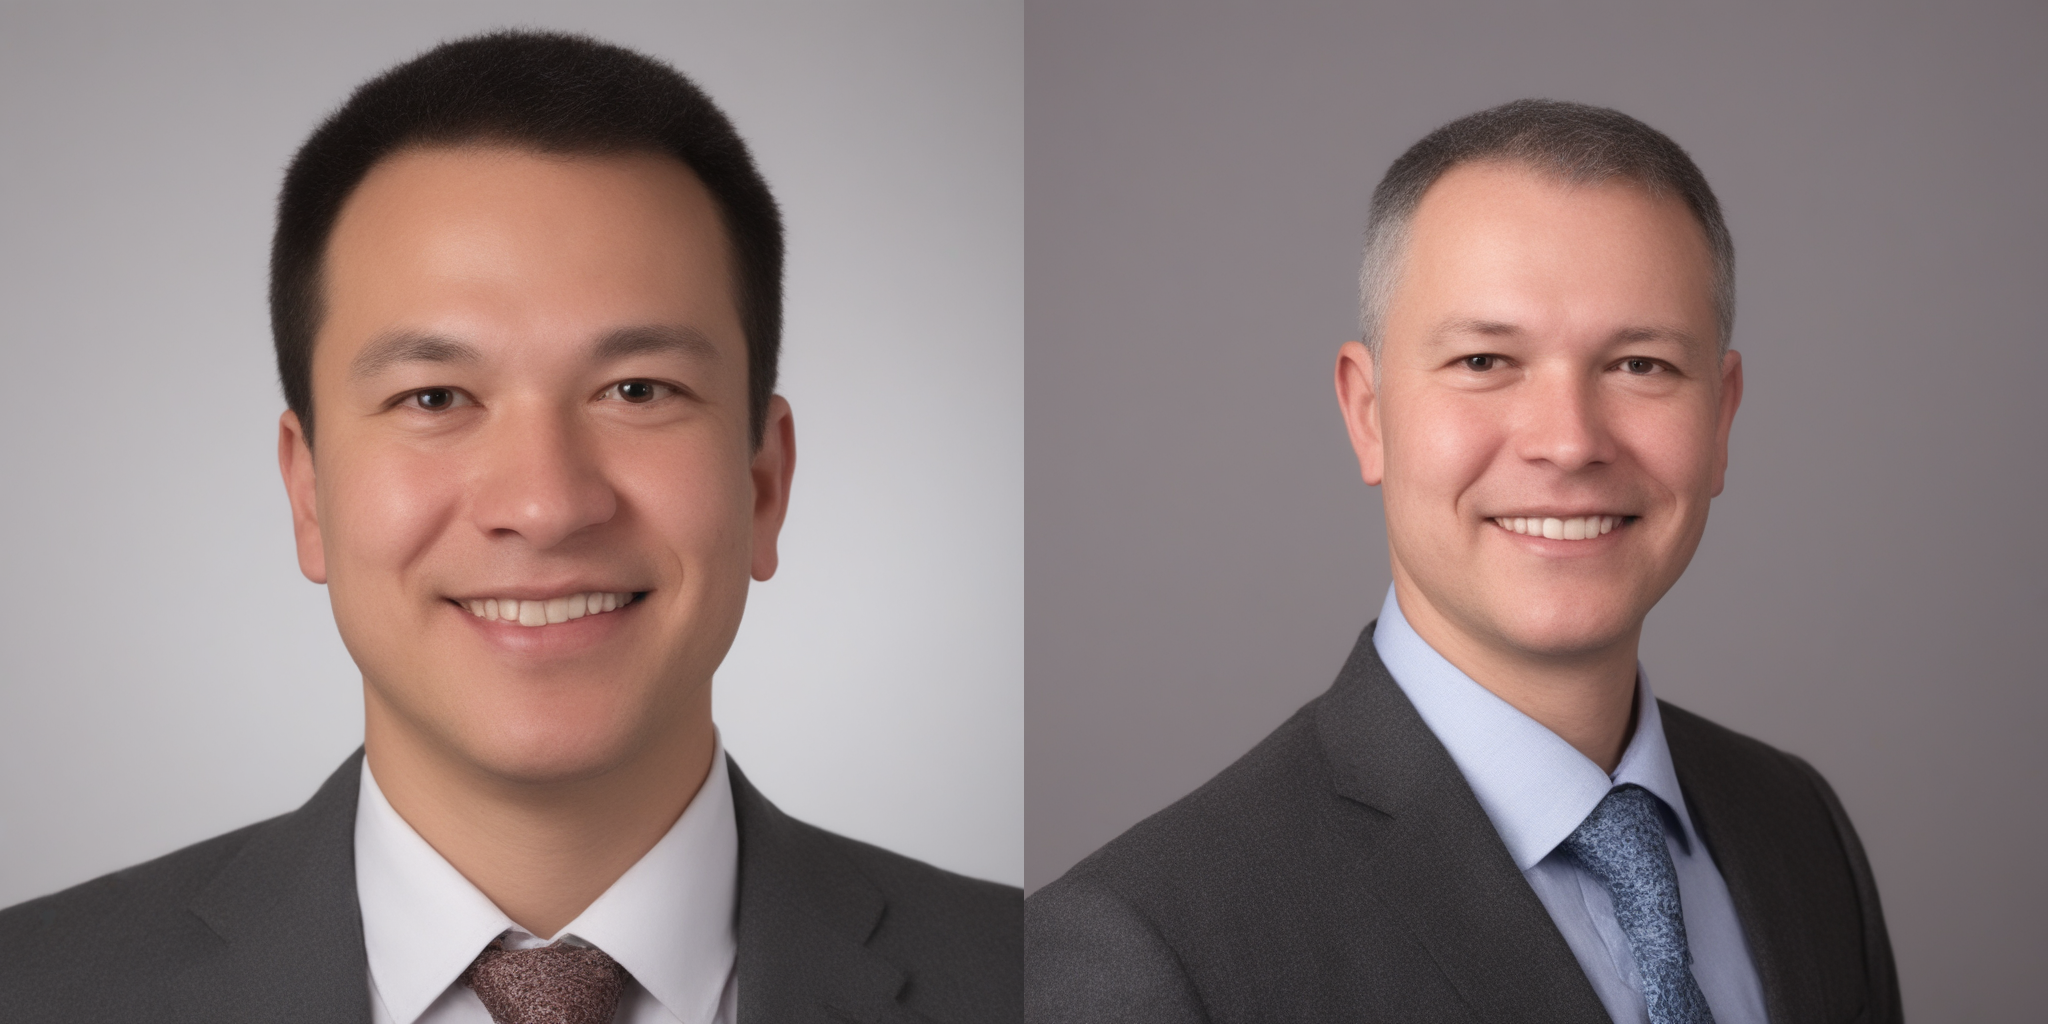

In [ ]:
images = pipe(**get_inputs(batch_size=2)).images
make_image_grid(images, rows=1, cols=2)

In [ ]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True,
).to("cuda")
pipeline.load_lora_weights("/content/drive/MyDrive/lora/sdxl/C00_003")
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_vae_slicing()
# pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
# pipeline.scheduler.use_karras_sigmas = True
pipeline.enable_attention_slicing()
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt = "business headshot of a <sks> man"

In [ ]:
def get_inputs(batch_size=1):
    # generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 40
    guidance_scale=15

    # return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps, "guidance_scale": guidance_scale}
    return {"prompt": prompts, "num_inference_steps": num_inference_steps, "guidance_scale": guidance_scale}

In [ ]:
# prompt += "frontal shot, serious look, business clothing, black suit"
# prompt += "50mm portrait photography, 8k, high definition, grey background"

In [ ]:
images = pipeline(**get_inputs(batch_size=2)).images
make_image_grid(images, rows=1, cols=2)

In [ ]:
del images
# del prompt
# del pipeline

In [ ]:
1/0

ZeroDivisionError: division by zero

## Inference Grid (SDXL)

In [ ]:
model_path ="/content/drive/MyDrive/lora/sdxl/C00_009"

In [ ]:
total_pipes = 3
pipes = []
schedulers = [DDIMScheduler, DDPMScheduler, DPMSolverMultistepScheduler]

In [ ]:
for i in range(total_pipes):
  pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True,
).to("cuda")
  pipe.load_lora_weights(model_path)

  pipe.enable_attention_slicing()
  pipe.enable_vae_slicing()
  pipe.scheduler = schedulers[i].from_config(pipe.scheduler.config)

  if pipe.scheduler == DPMSolverMultistepScheduler:
    pipe.scheduler.use_karras_sigmas = True
  pipe.enable_model_cpu_offload()
  pipes.append(pipe)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt = "business headshot of a ohwx man"
# prompt += "frontal shot, serious look, business clothing, black suit"
# prompt += "50mm portrait photography, 8k, high definition, grey background"
neg_prompt =""
# neg_prompt = "(((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquidtongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missingbreasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fusedears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, old photo, low res, black and white, black and white filter, colorless, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquid tongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missing breasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fused ears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, old photo, low res, black and white, black and white filter, colorless, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquid tongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missing breasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fused ears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, (((deformed))), blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, (extra_limb), (ugly), (poorly drawn hands), fused fingers, messy drawing, broken legs censor, censored, censor_bar, multiple breasts, (mutated hands and fingers:1.5), (long body :1.3), (mutation, poorly drawn :1.2), black-white, bad anatomy, liquid body, liquidtongue, disfigured, malformed, mutated, anatomical nonsense, text font ui, error, malformed hands, long neck, blurred, lowers, low res, bad anatomy, bad proportions, bad shadow, uncoordinated body, unnatural body, fused breasts, bad breasts, huge breasts, poorly drawn breasts, extra breasts, liquid breasts, heavy breasts, missingbreasts, huge haunch, huge thighs, huge calf, bad hands, fused hand, missing hand, disappearing arms, disappearing thigh, disappearing calf, disappearing legs, fusedears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears,"

In [ ]:
inf_start= 10
scale_start=5
max_inf_steps=40
max_scale=8
inf_step_increase=10
scale_increase=1

In [ ]:
grid_rows=int(max_scale-scale_start)
grid_cols=int((max_inf_steps-inf_start)/inf_step_increase)

In [ ]:
print(grid_rows)
print(grid_cols)

3
3


In [ ]:
def create_parameter_list(prompt, neg_prompt):
    """Creates a list of dictionaries containing the parameters.

    Args:
        prompt: The prompt for the model.
        neg_prompt: The negative prompt for the model.

    Returns:
        A list of dictionaries containing the parameters.
    """

    parameters = []
    for num_inference_steps in range(inf_start, max_inf_steps, inf_step_increase):
        for guidance_scale in range(scale_start, max_scale, scale_increase):
            parameters.append({
                "prompt": prompt,
                "neg_prompt": neg_prompt,
                "num_inference_steps": num_inference_steps,
                "guidance_scale": guidance_scale
            })
    return parameters

parameter_list = create_parameter_list(prompt, neg_prompt)

In [ ]:
def create_image_grid(images, columns, rows, figsize=(10,10),labels_x=None, labels_y=None):
    """
    Creates a grid of images using matplotlib and numpy.

    Args:
        images: A list of image data.
        columns: The number of columns in the grid.
        rows: The number of rows in the grid.
        labels_x: A list of labels for the x-axis (columns).
        labels_y: A list of labels for the y-axis (rows).

    Returns:
        The figure and axes objects.
    """

    fig, axs = plt.subplots(rows, columns, figsize=(10, 10))  # Adjust figure size as needed

    for i in range(rows):
        for j in range(columns):
            index = i * columns + j
            if index < len(images):
                axs[i, j].imshow(images[index])
                axs[i, j].tick_params(axis='both', length=0, width=0)
                axs[i, j].set_xticklabels([])
                axs[i, j].set_yticklabels([])
                axs[i, j].spines['top'].set_visible(False)
                axs[i, j].spines['right'].set_visible(False)
                axs[i, j].spines['bottom'].set_visible(False)
                axs[i, j].spines['left'].set_visible(False)

    # Add column labels
    if labels_x:
        for i in range(columns):
            axs[0, i].set_title(labels_x[i])

    # Add row labels
    if labels_y:
        for i in range(rows):
            axs[i, 0].set_ylabel(labels_y[i])

    return fig, axs

In [ ]:
inference_steps_list = my_list = list(OrderedDict.fromkeys([param["num_inference_steps"] for param in parameter_list]).keys())
guidance_scale_list = my_list = list(OrderedDict.fromkeys([param["guidance_scale"] for param in parameter_list]).keys())
labels_x = [f"Guidance Scale: {step}" for step in guidance_scale_list]
labels_y = [f"Inference Steps: {step}" for step in inference_steps_list]

In [ ]:
%%capture

pipe_outputs = []
for pipe in pipes:

    images = []
    for line in parameter_list:
        images.extend(pipe(prompt=prompt, neg_prompt=neg_prompt, num_inference_steps=line["num_inference_steps"], guidance_scale=line["guidance_scale"]).images)
    pipe_outputs.append(images)

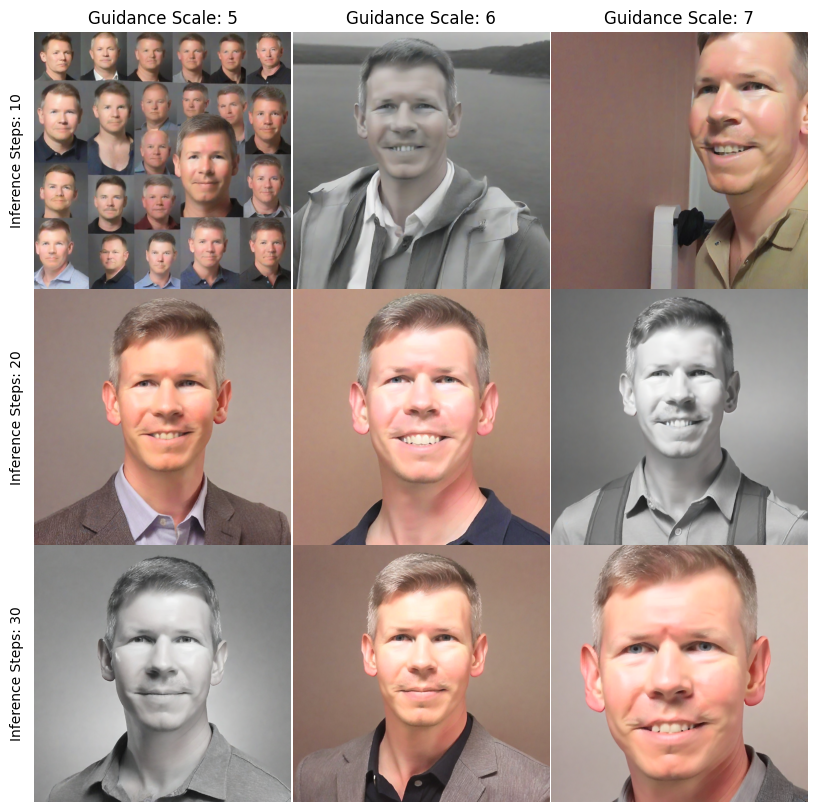

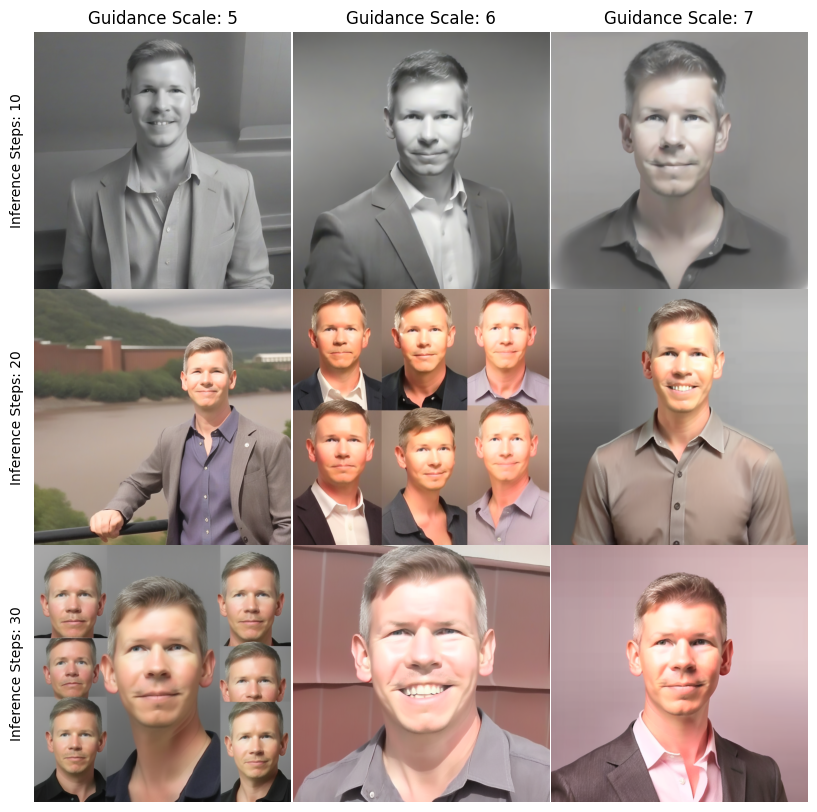

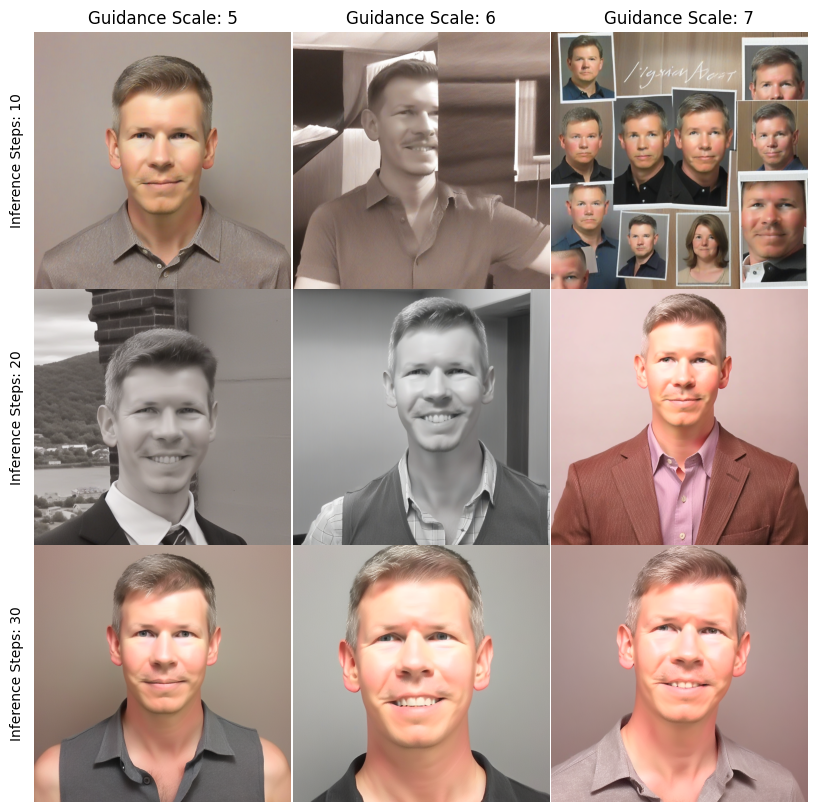

In [ ]:
plots = []
for output in pipe_outputs:
  fig, axs = create_image_grid(output, columns=grid_cols,rows=grid_rows, labels_x=labels_x, labels_y=labels_y)
  plt.subplots_adjust(hspace=0, wspace=0)
  plots.append(fig)
  plt.show()

## Save ...

### Single Image Download

In [ ]:
save_dir= "/content/drive/MyDrive/lora/sdxl/C00_009"

In [ ]:
def save_image_set(image_set, save_dir, set_name):
  """Saves an image set to a specified directory.

  Args:
    image_set: A list of images to save.
    output_dir: The root directory where the set will be saved.
    set_name: The name of the subdirectory for the set.
  """

  # Create the subdirectory for the set
  set_dir = os.path.join(save_dir, set_name)
  os.makedirs(set_dir, exist_ok=True)

  # Save each image in the set
  for i, image in enumerate(image_set):
    image_path = os.path.join(set_dir, f'image_{i}.jpg')  # Adjust file format as needed
    image.save(image_path)

In [ ]:
for i, output in enumerate(pipe_outputs):
    save_image_set(output, save_dir, f"inference_grid_single_images_{i:03d}")

In [ ]:
# import shutil

# shutil.rmtree("/content/drive")

### Save and Download Inference Grid Image

In [ ]:
counter =0
for plot in plots:
  counter= counter+1
  filepath = os.path.join(save_dir, f"Inference_Grid_{counter}")
  plot.savefig(filepath)

## clear memory

In [ ]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_reserved()/1024**2)


In [ ]:
import torch

def delete_pipeline(pipe):
  # del pipe.text_encoder, pipe.text_encoder_2, pipe.tokenizer, pipe.tokenizer_2, pipe.unet, pipe.vae
  del pipe.unet, pipe.vae, pipe.scheduler, pipe.tokenizer, pipe.text_encoder
  del pipe
  torch.cuda.empty_cache()
  memory_stats()

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()
memory_stats()

10.12646484375
42.0


<ipython-input-22-f37c257d42b3>:3: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(torch.cuda.memory_cached()/1024**2)


In [ ]:
delete_pipeline(pipes[1])

IndexError: list index out of range

In [ ]:
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 42           |        cudaMalloc retries: 47        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   9111 MiB |  21847 MiB |  18709 GiB |  18700 GiB |
|       from large pool |   9022 MiB |  21665 MiB |  18659 GiB |  18650 GiB |
|       from small pool |     89 MiB |    213 MiB |     49 GiB |     49 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   9111 MiB |  21847 MiB |  18709 GiB |  18700 GiB |
|       from large pool |   9022 MiB |  21665 MiB |  18659 GiB |

In [ ]:
for pipe in pipes:
  delete_pipeline(pipe)

AttributeError: unet